In [1]:
import json
import numpy as np
import pandas as pd
import requests
import rasterio
import itertools
import matplotlib.image
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

from pathlib import Path
from settings import username, password


In [2]:
catalogue_odata_url = "https://catalogue.dataspace.copernicus.eu/odata/v1"

collection_name = "SENTINEL-2"
product_type = "S2MSI2A"
max_cloud_cover = 1
corners = list(itertools.product(["20.95", "28.25"], ["55.7", "58.05"]))
poly = [" ".join(corners[i]) for i in [0, 2, 3, 1, 0]]
aoi = f"POLYGON(({",".join(poly)}))"
search_period_start = "2023-06-01T00:00:00.000Z"
search_period_end = "2023-06-10T00:00:00.000Z"


In [3]:
search_query = f"{catalogue_odata_url}/Products?$filter=Collection/Name eq '{collection_name}' and Attributes/OData.CSC.StringAttribute/any(att:att/Name eq 'productType' and att/OData.CSC.StringAttribute/Value eq '{product_type}') and OData.CSC.Intersects(area=geography'SRID=4326;{aoi}') and ContentDate/Start gt {search_period_start} and ContentDate/Start lt {search_period_end}"

print(f"""\n{search_query.replace(' ', "%20")}\n""")



https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI2A')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((20.95%2055.7,28.25%2055.7,28.25%2058.05,20.95%2058.05,20.95%2055.7))')%20and%20ContentDate/Start%20gt%202023-06-01T00:00:00.000Z%20and%20ContentDate/Start%20lt%202023-06-10T00:00:00.000Z



In [4]:
# filter by cloud coverage
search_query = f"{search_query} and Attributes/OData.CSC.DoubleAttribute/any(att:att/Name eq 'cloudCover' and att/OData.CSC.DoubleAttribute/Value le {max_cloud_cover})"
print(f"""\n{search_query.replace(' ', "%20")}\n""")

response = requests.get(search_query).json()
result = pd.DataFrame.from_dict(response["value"])

result.head(3)



https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20'SENTINEL-2'%20and%20Attributes/OData.CSC.StringAttribute/any(att:att/Name%20eq%20'productType'%20and%20att/OData.CSC.StringAttribute/Value%20eq%20'S2MSI2A')%20and%20OData.CSC.Intersects(area=geography'SRID=4326;POLYGON((20.95%2055.7,28.25%2055.7,28.25%2058.05,20.95%2058.05,20.95%2055.7))')%20and%20ContentDate/Start%20gt%202023-06-01T00:00:00.000Z%20and%20ContentDate/Start%20lt%202023-06-10T00:00:00.000Z%20and%20Attributes/OData.CSC.DoubleAttribute/any(att:att/Name%20eq%20'cloudCover'%20and%20att/OData.CSC.DoubleAttribute/Value%20le%201)



,@odata.mediaContentType,Id,Name,ContentType,ContentLength,OriginDate,PublicationDate,ModificationDate,Online,EvictionDate,S3Path,Checksum,ContentDate,Footprint,GeoFootprint
0,application/octet-stream,8b62c4bc-b821-41a2-92bb-22e85ac8f10a,S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_2...,application/octet-stream,967112358,2023-06-08T14:32:22.710000Z,2023-06-08T14:38:40.815723Z,2023-06-12T01:15:02.009415Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/06/08/S2B_MSIL...,"[{'Value': 'efe01d49fb0e7060348d8bd0ffc67305',...","{'Start': '2023-06-08T09:35:49.024000Z', 'End'...",geography'SRID=4326;POLYGON ((22.6793206704832...,"{'type': 'Polygon', 'coordinates': [[[22.67932..."
1,application/octet-stream,d26363c3-96c3-4e30-bc18-9e183d978a60,S2B_MSIL2A_20230608T093549_N0509_R036_T34VEK_2...,application/octet-stream,79626784,2023-06-08T15:19:30.858000Z,2023-06-08T15:27:01.959393Z,2023-06-12T03:12:43.823670Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/06/08/S2B_MSIL...,"[{'Value': 'cbe7a0efd7e8be352944aada6d05fc24',...","{'Start': '2023-06-08T09:35:49.024000Z', 'End'...",geography'SRID=4326;POLYGON ((22.4729991475233...,"{'type': 'Polygon', 'coordinates': [[[22.47299..."
2,application/octet-stream,fca55176-280b-4b53-bff4-6e1e4304e55a,S2A_MSIL2A_20230606T095031_N0509_R079_T35VLE_2...,application/octet-stream,1014805826,2023-06-06T16:09:20.251000Z,2023-06-06T16:34:23.882414Z,2023-06-10T23:16:58.453175Z,True,9999-12-31T23:59:59.999999Z,/eodata/Sentinel-2/MSI/L2A/2023/06/06/S2A_MSIL...,"[{'Value': '9083670d53d2c9d13b37062422a91991',...","{'Start': '2023-06-06T09:50:31.025000Z', 'End'...",geography'SRID=4326;POLYGON ((25.4706149028949...,"{'type': 'Polygon', 'coordinates': [[[25.47061..."


In [5]:
auth_server_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
data = {
    "client_id": "cdse-public",
    "grant_type": "password",
    "username": username,
    "password": password,
}


In [6]:
#for i,r in result.head(3).iterrows():
for i,r in result.iterrows():
    response = requests.post(auth_server_url, data=data, verify=True, allow_redirects=False)
    access_token = json.loads(response.text)["access_token"]

    session = requests.Session()
    session.headers["Authorization"] = f"Bearer {access_token}"
    
    product_identifier = r["Id"]
    product_name = r["Name"]

    url = f"{catalogue_odata_url}/Products({product_identifier})/Nodes({product_name})/Nodes(MTD_MSIL2A.xml)/$value"
    print(url)
    
    response = session.get(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers["Location"]
        response = session.get(url, allow_redirects=False)
        print(response)
    file = session.get(url, verify=False, allow_redirects=True)
    outfile = Path.home() / f"Projs/bulbulis/data/MTD_{product_name}_MSIL2A.xml"
    outfile.write_bytes(file.content)

    tree = ET.parse(str(outfile))
    root = tree.getroot()
    band_location = [f"{product_name}/{e.text}.jp2".split("/") for e in root[0][0][12][0][0] if "B02_10m" in e.text or "B03_10m" in e.text or "B04_10m" in e.text or "B08_10m" in e.text or "SCL_20m" in e.text]

    bands = []
    for band_file in band_location:
        url = f"{catalogue_odata_url}/Products({product_identifier})/{"/".join([f"Nodes({b})" for b in band_file])}/$value"
        response = session.get(url, allow_redirects=False)
        while response.status_code in (301, 302, 303, 307):
            url = response.headers["Location"]
            response = session.get(url, allow_redirects=False)
        file = session.get(url, verify=False, allow_redirects=True)
        
        outfile = Path.home() / f"Projs/bulbulis/data/{band_file[-1]}"
        outfile.write_bytes(file.content)
        bands.append(str(outfile))
        print("Saved:", band_file[-1])
    
    try:
        red = rasterio.open([b for b in bands if "B04_10m" in b][0], driver="JP2OpenJPEG").read(1)
        green = rasterio.open([b for b in bands if "B03_10m" in b][0], driver="JP2OpenJPEG").read(1)
        blue = rasterio.open([b for b in bands if "B02_10m" in b][0], driver="JP2OpenJPEG").read(1)
    
        gain = 2
        red_n = np.clip(red * gain / 10000, 0, 1)
        green_n = np.clip(green * gain / 10000, 0, 1)
        blue_n = np.clip(blue * gain / 10000, 0, 1)
        rgb_composite_n = np.dstack((red_n, green_n, blue_n))
        #plt.imshow(rgb_composite_n)
        outfile = f"{Path.home()}/Projs/bulbulis/images/Sentinel2_{product_name}_true_color_base.jpeg"
        matplotlib.image.imsave(outfile, rgb_composite_n)
        print("Saved as:", outfile)
    except BaseException as e:
        print(f"ERROR: {product_name} failed with {e}")
    

https://catalogue.dataspace.copernicus.eu/odata/v1/Products(8b62c4bc-b821-41a2-92bb-22e85ac8f10a)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T34VFJ_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(d26363c3-96c3-4e30-bc18-9e183d978a60)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T34VEK_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T34VEK_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(fca55176-280b-4b53-bff4-6e1e4304e55a)/Nodes(S2A_MSIL2A_20230606T095031_N0509_R079_T35VLE_20230606T140554.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLE_20230606T095031_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLE_20230606T095031_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLE_20230606T095031_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLE_20230606T095031_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLE_20230606T095031_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2A_MSIL2A_20230606T095031_N0509_R079_T35VLE_20230606T140554.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(18d1299a-adec-4665-8cb5-fc07314bf0b4)/Nodes(S2B_MSIL2A_20230601T094549_N0509_R079_T35ULB_20230601T123133.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230601T094549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230601T094549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230601T094549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230601T094549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230601T094549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230601T094549_N0509_R079_T35ULB_20230601T123133.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(9f8a4458-f073-474e-8164-40a36d6b5ef3)/Nodes(S2A_MSIL2A_20230606T095031_N0509_R079_T34UDG_20230606T140554.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UDG_20230606T095031_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UDG_20230606T095031_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UDG_20230606T095031_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UDG_20230606T095031_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UDG_20230606T095031_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2A_MSIL2A_20230606T095031_N0509_R079_T34UDG_20230606T140554.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(7c372aad-635d-45d8-9431-d63f6ce16f43)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T35VME_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VME_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VME_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VME_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VME_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VME_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T35VME_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(a0d1d3cd-28f5-47d4-9528-be1ac5acfe82)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T35VND_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VND_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VND_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VND_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VND_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VND_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T35VND_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(421c81e3-ba82-4e9f-843f-d6004a77e5e8)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VEK_20230609T132603.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230609T100031_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230609T100031_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230609T100031_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230609T100031_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEK_20230609T100031_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2A_MSIL2A_20230609T100031_N0509_R122_T34VEK_20230609T132603.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(6e407408-8ad7-4eb3-aaba-7d88577aa3f8)/Nodes(S2A_MSIL2A_20230606T095031_N0509_R079_T34VFK_20230606T140554.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230606T095031_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230606T095031_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230606T095031_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230606T095031_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230606T095031_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2A_MSIL2A_20230606T095031_N0509_R079_T34VFK_20230606T140554.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(036fee75-86e1-4a59-8d20-3671deb5aed5)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T35VMD_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VMD_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VMD_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VMD_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VMD_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VMD_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T35VMD_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(1bf58838-cdc5-4937-9f51-988f94066d4c)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T35VNC_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNC_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNC_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNC_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNC_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNC_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T35VNC_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(f67b503f-f319-42f2-8918-7ca607f79571)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T35VLD_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLD_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLD_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLD_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLD_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VLD_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T35VLD_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(ef32e2f7-3869-4f29-a496-c3231c303abd)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T34UEG_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UEG_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UEG_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UEG_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UEG_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UEG_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T34UEG_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(cfd9a8c9-6d0a-4a8c-ae32-407119e4ecc5)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T34VEJ_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T34VEJ_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(4703bc75-bc50-445f-a061-5e9add9f9544)/Nodes(S2A_MSIL2A_20230606T095031_N0509_R079_T35ULB_20230606T140554.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230606T095031_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230606T095031_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230606T095031_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230606T095031_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35ULB_20230606T095031_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2A_MSIL2A_20230606T095031_N0509_R079_T35ULB_20230606T140554.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(0fa7bf1c-873e-4cd0-b597-442d617cbef0)/Nodes(S2A_MSIL2A_20230606T095031_N0509_R079_T34UFG_20230606T140554.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UFG_20230606T095031_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UFG_20230606T095031_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UFG_20230606T095031_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UFG_20230606T095031_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34UFG_20230606T095031_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2A_MSIL2A_20230606T095031_N0509_R079_T34UFG_20230606T140554.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(5590c51e-86c6-412b-80a5-99824d769f96)/Nodes(S2B_MSIL2A_20230608T093549_N0509_R036_T35VNE_20230608T112304.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNE_20230608T093549_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNE_20230608T093549_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNE_20230608T093549_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNE_20230608T093549_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T35VNE_20230608T093549_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2B_MSIL2A_20230608T093549_N0509_R036_T35VNE_20230608T112304.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(861f6915-2f0c-4306-ab86-74ff4942d461)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(a1857717-bc47-4eaf-a455-45181c173e62)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VFJ_20230609T132603.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230609T100031_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230609T100031_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230609T100031_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230609T100031_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFJ_20230609T100031_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2A_MSIL2A_20230609T100031_N0509_R122_T34VFJ_20230609T132603.SAFE_true_color_base.jpeg
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(713631c7-83c5-420a-a73f-498837e51234)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VFK_20230609T132603.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230609T100031_B02_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230609T100031_B03_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230609T100031_B04_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230609T100031_B08_10m.jp2


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VFK_20230609T100031_SCL_20m.jp2
Saved as: /Users/kristaps/Projs/bulbulis/images/Sentinel2_S2A_MSIL2A_20230609T100031_N0509_R122_T34VFK_20230609T132603.SAFE_true_color_base.jpeg


In [79]:
product_identifier = result.iloc[0, 1]
product_name = result.iloc[0, 2]

session = requests.Session()
session.headers["Authorization"] = f"Bearer {access_token}"


In [ ]:
response = requests.post(auth_server_url, data=data, verify=True, allow_redirects=False)
access_token = json.loads(response.text)["access_token"]


In [80]:
url = f"{catalogue_odata_url}/Products({product_identifier})/Nodes({product_name})/Nodes(MTD_MSIL2A.xml)/$value"

print(url)

response = session.get(url, allow_redirects=False)
while response.status_code in (301, 302, 303, 307):
    url = response.headers["Location"]
    response = session.get(url, allow_redirects=False)
    print(response)

file = session.get(url, verify=False, allow_redirects=True)

print(file)

outfile = Path.home() / f"Projs/bulbulis/data/MTD_MSIL2A.xml"
outfile.write_bytes(file.content)


https://catalogue.dataspace.copernicus.eu/odata/v1/Products(861f6915-2f0c-4306-ab86-74ff4942d461)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE)/Nodes(MTD_MSIL2A.xml)/$value
<Response [200]>


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


<Response [200]>


54957

In [81]:
tree = ET.parse(str(outfile))
root = tree.getroot()

# B04 and B08 for calculating NDVI => ((B08-B04)/(B08+B04))
# NDVI > 7 indicates presence of forest
#
# SCL for working out if what we're seeing is a cloud
# discard if SCL includes ones of invalid = [
#     0, // NO_DATA
#     1, // SATURATED_DEFECTIVE
#     3, // CLOUD_SHADOW
#     7, // CLOUD_LOW_PROBA
#     8, // CLOUD_MEDIUM_PROBA
#     9, // CLOUD_HIGH_PROBA
#     10 // THIN_CIRRUS
# ]
band_location = [f"{product_name}/{e.text}.jp2".split("/") for e in root[0][0][12][0][0] if "B02_10m" in e.text or "B03_10m" in e.text or "B04_10m" in e.text or "B08_10m" in e.text or "SCL_20m" in e.text]


In [82]:
band_location

[['S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE',
  'GRANULE',
  'L2A_T34VEJ_A041589_20230609T100029',
  'IMG_DATA',
  'R10m',
  'T34VEJ_20230609T100031_B02_10m.jp2'],
 ['S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE',
  'GRANULE',
  'L2A_T34VEJ_A041589_20230609T100029',
  'IMG_DATA',
  'R10m',
  'T34VEJ_20230609T100031_B03_10m.jp2'],
 ['S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE',
  'GRANULE',
  'L2A_T34VEJ_A041589_20230609T100029',
  'IMG_DATA',
  'R10m',
  'T34VEJ_20230609T100031_B04_10m.jp2'],
 ['S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE',
  'GRANULE',
  'L2A_T34VEJ_A041589_20230609T100029',
  'IMG_DATA',
  'R10m',
  'T34VEJ_20230609T100031_B08_10m.jp2'],
 ['S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE',
  'GRANULE',
  'L2A_T34VEJ_A041589_20230609T100029',
  'IMG_DATA',
  'R20m',
  'T34VEJ_20230609T100031_SCL_20m.jp2']]

In [83]:
bands = []
for band_file in band_location:
    url = f"{catalogue_odata_url}/Products({product_identifier})/{"/".join([f"Nodes({b})" for b in band_file])}/$value"
    print(url)
    response = session.get(url, allow_redirects=False)
    while response.status_code in (301, 302, 303, 307):
        url = response.headers["Location"]
        response = session.get(url, allow_redirects=False)
    file = session.get(url, verify=False, allow_redirects=True)
    
    outfile = Path.home() / f"Projs/bulbulis/data/{band_file[-1]}"
    outfile.write_bytes(file.content)
    bands.append(str(outfile))
    print("Saved:", band_file[-1])
    

https://catalogue.dataspace.copernicus.eu/odata/v1/Products(861f6915-2f0c-4306-ab86-74ff4942d461)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE)/Nodes(GRANULE)/Nodes(L2A_T34VEJ_A041589_20230609T100029)/Nodes(IMG_DATA)/Nodes(R10m)/Nodes(T34VEJ_20230609T100031_B02_10m.jp2)/$value


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_B02_10m.jp2
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(861f6915-2f0c-4306-ab86-74ff4942d461)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE)/Nodes(GRANULE)/Nodes(L2A_T34VEJ_A041589_20230609T100029)/Nodes(IMG_DATA)/Nodes(R10m)/Nodes(T34VEJ_20230609T100031_B03_10m.jp2)/$value


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_B03_10m.jp2
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(861f6915-2f0c-4306-ab86-74ff4942d461)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE)/Nodes(GRANULE)/Nodes(L2A_T34VEJ_A041589_20230609T100029)/Nodes(IMG_DATA)/Nodes(R10m)/Nodes(T34VEJ_20230609T100031_B04_10m.jp2)/$value


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_B04_10m.jp2
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(861f6915-2f0c-4306-ab86-74ff4942d461)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE)/Nodes(GRANULE)/Nodes(L2A_T34VEJ_A041589_20230609T100029)/Nodes(IMG_DATA)/Nodes(R10m)/Nodes(T34VEJ_20230609T100031_B08_10m.jp2)/$value


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_B08_10m.jp2
https://catalogue.dataspace.copernicus.eu/odata/v1/Products(861f6915-2f0c-4306-ab86-74ff4942d461)/Nodes(S2A_MSIL2A_20230609T100031_N0509_R122_T34VEJ_20230609T132603.SAFE)/Nodes(GRANULE)/Nodes(L2A_T34VEJ_A041589_20230609T100029)/Nodes(IMG_DATA)/Nodes(R20m)/Nodes(T34VEJ_20230609T100031_SCL_20m.jp2)/$value


/Users/kristaps/Projs/bulbulis/.venv/lib/python3.13/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'download.dataspace.copernicus.eu'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Saved: T34VEJ_20230609T100031_SCL_20m.jp2


In [84]:
bands

['/Users/kristaps/Projs/bulbulis/data/T34VEJ_20230609T100031_B02_10m.jp2',
 '/Users/kristaps/Projs/bulbulis/data/T34VEJ_20230609T100031_B03_10m.jp2',
 '/Users/kristaps/Projs/bulbulis/data/T34VEJ_20230609T100031_B04_10m.jp2',
 '/Users/kristaps/Projs/bulbulis/data/T34VEJ_20230609T100031_B08_10m.jp2',
 '/Users/kristaps/Projs/bulbulis/data/T34VEJ_20230609T100031_SCL_20m.jp2']

In [85]:
red = rasterio.open([b for b in bands if "B04_10m" in b][0], driver="JP2OpenJPEG").read(1)
green = rasterio.open([b for b in bands if "B03_10m" in b][0], driver="JP2OpenJPEG").read(1)
blue = rasterio.open([b for b in bands if "B02_10m" in b][0], driver="JP2OpenJPEG").read(1)


Saved as: /Users/kristaps/Projs/bulbulis/Sentinel2_true_color_base.jpeg


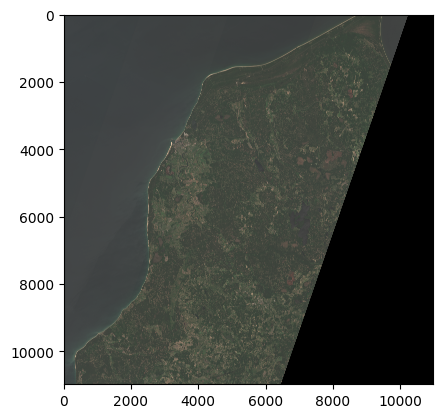

In [86]:
gain = 2

# Normalize the pixel values and apply gain
red_n = np.clip(red * gain / 10000, 0, 1)
green_n = np.clip(green * gain / 10000, 0, 1)
blue_n = np.clip(blue * gain / 10000, 0, 1)

# Create composite image
rgb_composite_n = np.dstack((red_n, green_n, blue_n))

# Display image
plt.imshow(rgb_composite_n)

# Save image to file
outfile = f"{Path.home()}/Projs/bulbulis/Sentinel2_true_color_base.jpeg"
matplotlib.image.imsave(outfile, rgb_composite_n)
print("Saved as:", outfile)
